In [1]:
#install and download needed packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import scipy
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor,BaggingRegressor,GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,KFold
from sklearn.metrics import mean_squared_error,accuracy_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA
import statsmodels.api as sm
warnings.filterwarnings('ignore')

In [2]:
data= pd.read_csv('Volkswagen.csv')

In [3]:
data.shape 

(6552, 7)

In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1998-07-28,59.209850,61.445404,57.837109,58.294357,23.145239,116194
1,1998-07-29,58.345055,60.988155,57.430553,59.717796,23.710396,95068
2,1998-07-30,59.971272,61.750568,59.971272,60.836071,24.154402,51306
3,1998-07-31,61.750568,61.750568,56.160194,60.836071,24.154402,145369
4,1998-08-03,55.397781,55.778492,55.143311,55.702946,22.116343,74948


In [5]:
data.index 

RangeIndex(start=0, stop=6552, step=1)

In [6]:
data=data.rename(columns={'Date':'date','Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'})

In [7]:
data=data.drop(columns=['Adj Close'],axis=1)

In [8]:
data['date']=pd.to_datetime(data['date'])

In [9]:
data.set_index('date', inplace=True)

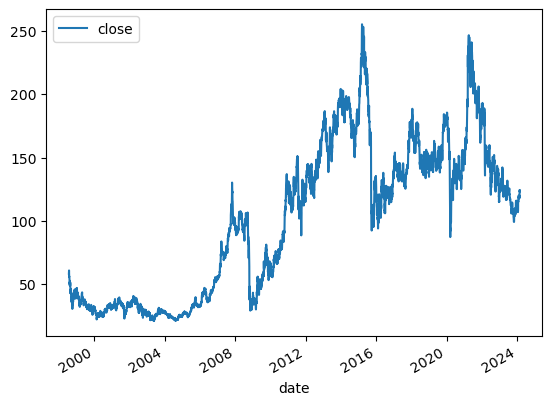

In [10]:
data.plot.line(y='close', use_index=True)
plt.savefig('Volkswagen.png');

In [11]:
data.describe()

,open,high,low,close,volume
count,6552.000000,6552.000000,6552.000000,6552.000000,6.552000e+03
mean,99.874526,101.169583,98.391928,99.814576,8.794061e+05
std,60.073163,60.666549,59.379260,59.984565,9.791585e+05
min,20.546413,21.222347,20.476831,20.924141,0.000000e+00
25%,35.287743,35.971133,34.591930,35.285258,2.378848e+05
50%,107.232399,108.924999,105.417904,107.521564,7.337200e+05
75%,146.199997,148.000000,144.152496,145.919998,1.169220e+06
max,259.500000,262.450012,249.550003,255.199997,1.753497e+07


In [11]:
data= data[data.index<='2021']

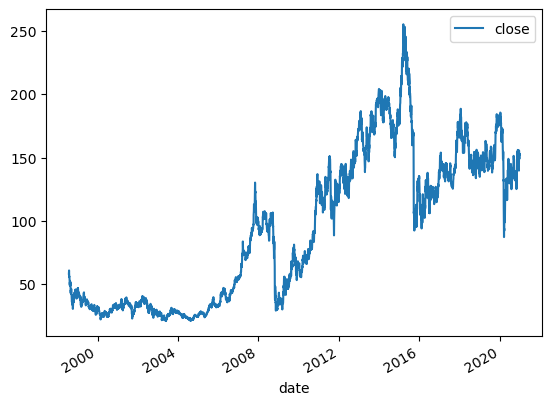

In [12]:
data.plot.line(y='close', use_index=True);

In [13]:
data['Tomorrow']=data['close'].shift(-1)

In [14]:
data.head() 

,open,high,low,close,volume,Tomorrow
date,,,,,,
1998-07-28,59.209850,61.445404,57.837109,58.294357,116194,59.717796
1998-07-29,58.345055,60.988155,57.430553,59.717796,95068,60.836071
1998-07-30,59.971272,61.750568,59.971272,60.836071,51306,60.836071
1998-07-31,61.750568,61.750568,56.160194,60.836071,145369,55.702946
1998-08-03,55.397781,55.778492,55.143311,55.702946,74948,55.905727


In [15]:
data['previousday']=data['close'].shift(1)

In [16]:
data.head()

,open,high,low,close,volume,Tomorrow,previousday
date,,,,,,,
1998-07-28,59.209850,61.445404,57.837109,58.294357,116194,59.717796,NaN
1998-07-29,58.345055,60.988155,57.430553,59.717796,95068,60.836071,58.294357
1998-07-30,59.971272,61.750568,59.971272,60.836071,51306,60.836071,59.717796
1998-07-31,61.750568,61.750568,56.160194,60.836071,145369,55.702946,60.836071
1998-08-03,55.397781,55.778492,55.143311,55.702946,74948,55.905727,60.836071


In [17]:
data.shape

(5744, 7)

In [18]:
train = data.iloc[:-1000]
test = data.iloc[-1000:]

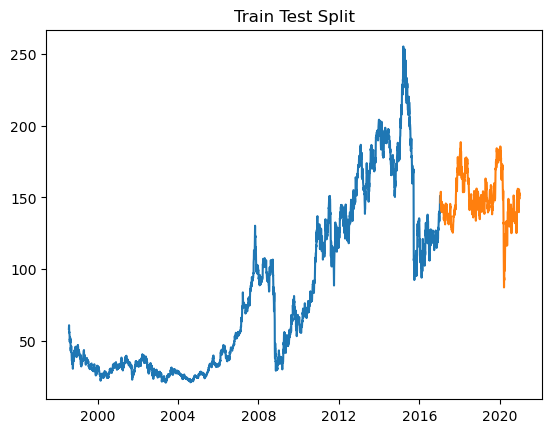

In [19]:
import matplotlib.pyplot as plt 
plt.plot(train['close'], label='train')
plt.plot(test['close'], label='test')
plt.title('Train Test Split');

In [20]:
# Utility function
def evaluate_model(model, x, y):
    """
    Utility function to print the model performance, (MAE and MAPE)
    model: Fitted model
    x:  features dataset
    y:  target values
    """
    predicted = model.predict(x) #get predictions
    mae = mean_absolute_error(y_true=y, y_pred=predicted)
    abs_errors= np.abs(np.array(predicted) - np.array(y))
    min_abs_errors= np.min(abs_errors)
    max_abs_errors= np.max(abs_errors)
    med_abs_errors= np.median(abs_errors)
    mape = mean_absolute_percentage_error(y, predicted)

    print('MAE: {:.2f}'.format(mae))
    print('MAPE: {:.2f}'.format(mape))
    print('minae: {:.2f}'.format(min_abs_errors))
    print('maxae: {:.2f}'.format(max_abs_errors))
    print('medae: {:.2f}'.format(med_abs_errors))
    print()

In [21]:
#predictors_1 = ["close", "volume", "open", "high", "low"]
predictors_2 = ["volume", "open", "high", "low"]

In [22]:
# creating a dictionary of Regressors to be experimented on.
models_dict = {
          'RF Regressor':RandomForestRegressor(random_state=0),
          'xgboost': XGBRegressor(),'Gradient Boost': GradientBoostingRegressor(random_state=0),
    'Catboostregressor':CatBoostRegressor(iterations=100, early_stopping_rounds=50)
         }

#looping through all the regressors, fitting and evaluating them on  test data respectively
for key, model in models_dict.items():
    model.fit(train[predictors_2], train['close'])
    print(f'Performance of "{key}" on Validation and Test set:')
    print('=='*28)
    print ( 'Test set:')
    print("**"*8)
    evaluate_model(model,test[predictors_2], test['close'])





Performance of "RF Regressor" on Validation and Test set:
Test set:
****************
MAE: 0.91
MAPE: 0.01
minae: 0.00
maxae: 6.60
medae: 0.73

Performance of "xgboost" on Validation and Test set:
Test set:
****************
MAE: 1.06
MAPE: 0.01
minae: 0.00
maxae: 6.56
medae: 0.84

Performance of "Gradient Boost" on Validation and Test set:
Test set:
****************
MAE: 1.19
MAPE: 0.01
minae: 0.00
maxae: 6.80
medae: 1.00

Learning rate set to 0.340416
0:	learn: 39.3922377	total: 142ms	remaining: 14.1s
1:	learn: 26.8411997	total: 144ms	remaining: 7.06s
2:	learn: 18.4065302	total: 146ms	remaining: 4.72s
3:	learn: 12.6543349	total: 148ms	remaining: 3.55s
4:	learn: 8.8932175	total: 151ms	remaining: 2.87s
5:	learn: 6.5282734	total: 153ms	remaining: 2.4s
6:	learn: 5.0368750	total: 155ms	remaining: 2.06s
7:	learn: 4.0842390	total: 157ms	remaining: 1.81s
8:	learn: 3.5482888	total: 159ms	remaining: 1.61s
9:	learn: 3.2751983	total: 161ms	remaining: 1.45s
10:	learn: 3.0474430	total: 163ms	remaini

#### Retrain the best Model(Extreme Gradient Boosting)

In [23]:
model= GradientBoostingRegressor()
model.fit(train[predictors_2], train['close'])
pred= model.predict(test[predictors_2])

In [24]:

pred= pd.Series(pred, index=test.index)
combined_2= pd.concat([test['close'], pred],axis=1)

In [25]:
#combined_1.plot();
combined_2

,close,0
date,,
2017-01-18,146.399994,146.336528
2017-01-19,147.800003,147.092687
2017-01-20,148.199997,147.395956
2017-01-23,152.800003,152.101181
2017-01-24,153.600006,155.675665
...,...,...
2020-12-22,148.899994,148.371378
2020-12-23,152.460007,152.121795
2020-12-28,152.759995,155.779883


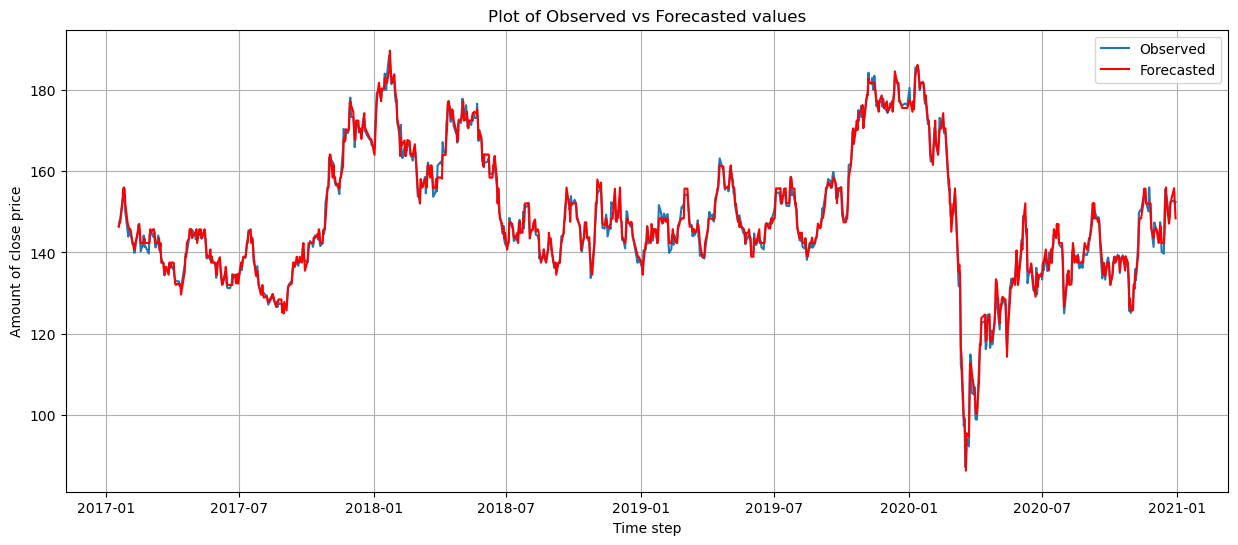

In [26]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined_2['close'], label='Observed')
plt.plot(combined_2[0], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

In [27]:
#add additional predictors to the model
#calculate the mean close price in certain days and  find the ratio between today's closing price and that of the periods
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = data.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    data[ratio_column] = data["close"] / rolling_averages["close"]
    
    trend_column = f"Trend_{horizon}"
    data[trend_column] = data.shift(1).rolling(horizon).sum()["close"]
    
    
    
    new_predictors+= [ratio_column, trend_column]

In [28]:
data['mom'] = data['close'].pct_change(12) # 12 month change

In [29]:
#Create the RSI indicator
#data['rsi' + str(n)] = talib.RSI(data['close'].values, timeperiod=horizon)
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [30]:
data['RSI']= computeRSI(data['close'], 14)

In [31]:
data.head()

,open,high,low,close,volume,Tomorrow,previousday,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,mom,RSI
date,,,,,,,,,,,,,,,,,,,
1998-07-28,59.209850,61.445404,57.837109,58.294357,116194,59.717796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-07-29,58.345055,60.988155,57.430553,59.717796,95068,60.836071,58.294357,1.012062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-07-30,59.971272,61.750568,59.971272,60.836071,51306,60.836071,59.717796,1.009276,118.012153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-07-31,61.750568,61.750568,56.160194,60.836071,145369,55.702946,60.836071,1.000000,120.553867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-08-03,55.397781,55.778492,55.143311,55.702946,74948,55.905727,60.836071,0.955954,121.672142,0.94288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
data.shape 

(5744, 19)

In [33]:
new_data=data[new_predictors]
new_data['close']=data['close']
new_data['MOM']=data['mom']
new_data.head()

,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,close,MOM
date,,,,,,,,,,,,
1998-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.294357,NaN
1998-07-29,1.012062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.717796,NaN
1998-07-30,1.009276,118.012153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.836071,NaN
1998-07-31,1.000000,120.553867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.836071,NaN
1998-08-03,0.955954,121.672142,0.94288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.702946,NaN


In [34]:
new_data['SMA_3'] = new_data.iloc[:,10].rolling(window=3).mean()
new_data['SMA_4'] = new_data.iloc[:,10].rolling(window=4).mean()

In [35]:
new_data['CMA_4'] = new_data['close'].expanding(min_periods=4).mean()

In [36]:
new_data['EMA'] = new_data.iloc[:,10].ewm(span=40,adjust=False).mean()

In [37]:
new_data=new_data.dropna()
new_data.shape 

(4744, 16)

In [38]:
new_data.head()

,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,close,MOM,SMA_3,SMA_4,CMA_4,EMA
date,,,,,,,,,,,,,,,,
2002-05-28,0.996030,78.030644,0.994171,193.535878,1.027513,2256.109469,1.146909,8424.556161,1.149514,33649.031590,38.657475,0.080278,38.896040,38.863734,33.654035,37.279429
2002-05-29,0.997422,77.623097,0.991644,194.420556,1.021559,2257.342055,1.140781,8426.444803,1.144326,33629.394708,38.458672,0.045676,38.693923,38.786698,33.658830,37.336953
2002-05-30,0.987968,77.116147,0.974207,193.913606,0.997061,2258.823150,1.113431,8428.144579,1.117890,33608.135584,37.544170,0.007469,38.220106,38.406485,33.662704,37.347062
2002-05-31,1.005005,76.002842,0.989881,192.690961,1.006782,2259.290339,1.124265,8429.834413,1.129908,33584.843683,37.921898,0.047214,37.974913,38.145554,33.666946,37.375102
2002-06-03,0.980628,75.466068,0.964774,191.547837,0.968751,2259.986151,1.081357,8432.597791,1.087586,33561.929510,36.480568,-0.019503,37.315545,37.601327,33.669746,37.331466


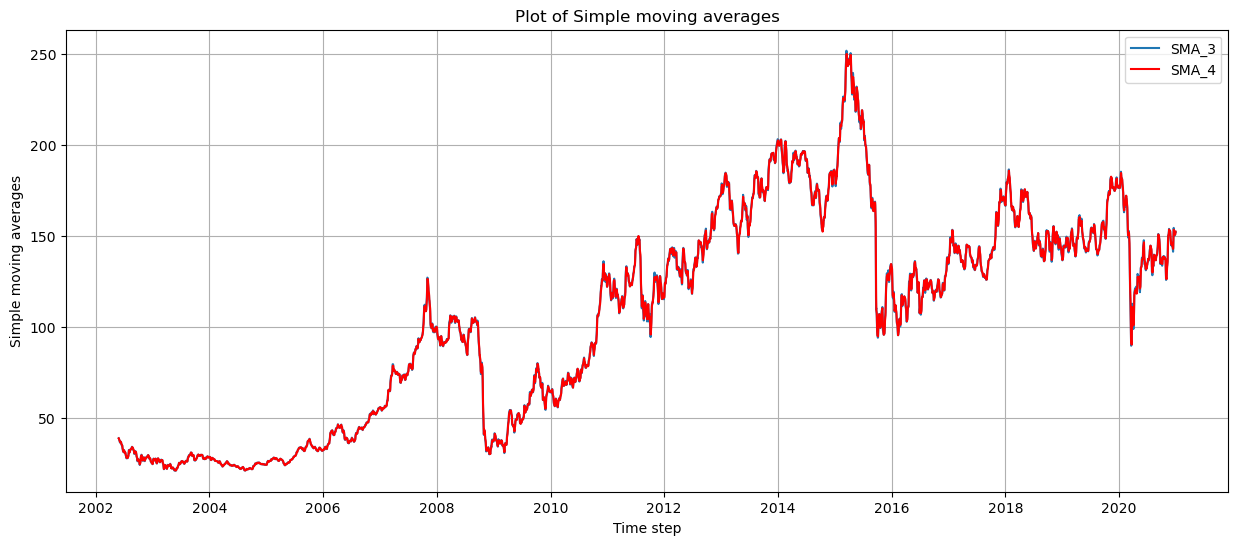

In [39]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['SMA_3'], label='SMA_3')
plt.plot(new_data['SMA_4'], color='r', label='SMA_4')
plt.title('Plot of Simple moving averages')
plt.ylabel('Simple moving averages')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

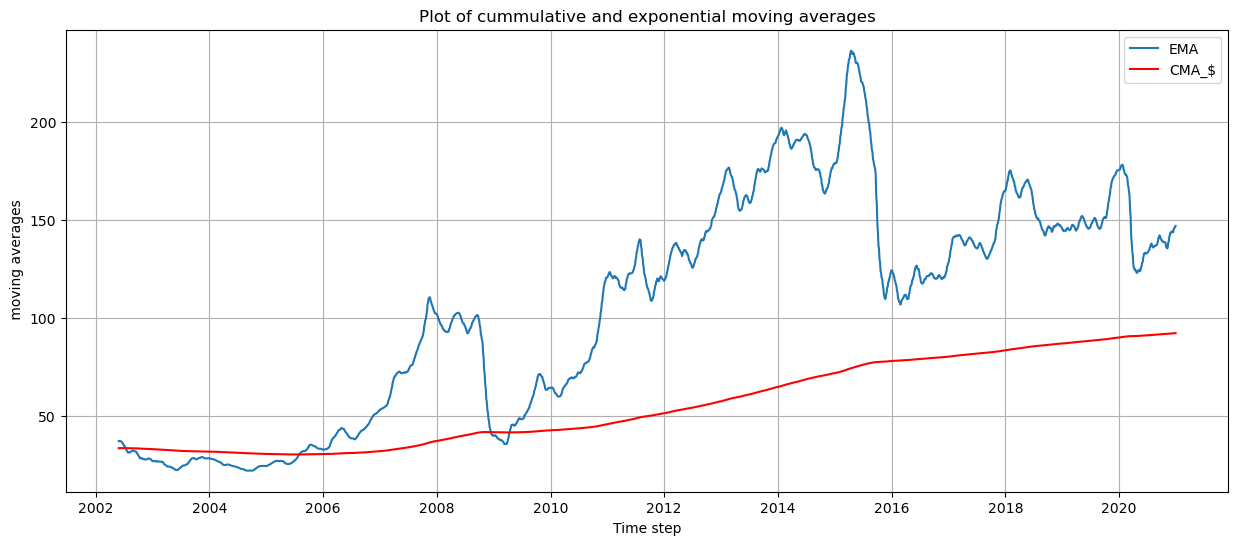

In [40]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['EMA'], label='EMA')
plt.plot(new_data['CMA_4'], color='r', label='CMA_$')
plt.title('Plot of cummulative and exponential moving averages')
plt.ylabel(' moving averages')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

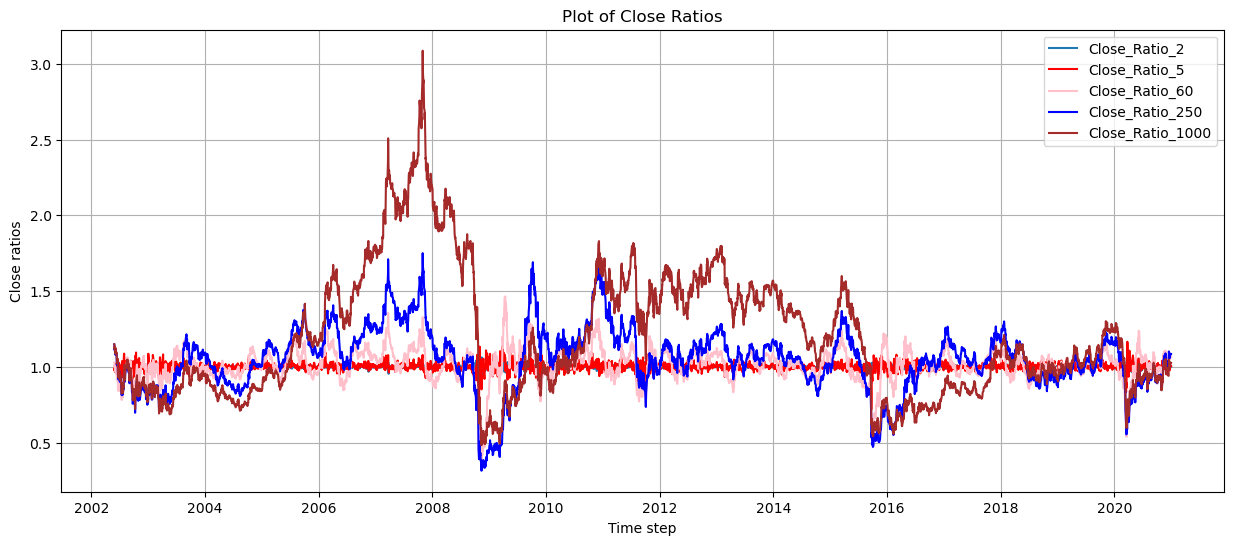

In [41]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['Close_Ratio_2'], label='Close_Ratio_2')
plt.plot(new_data['Close_Ratio_5'], color='r', label='Close_Ratio_5')
plt.plot(new_data['Close_Ratio_60'], color='pink', label='Close_Ratio_60')
plt.plot(new_data['Close_Ratio_250'], color='b', label='Close_Ratio_250')
plt.plot(new_data['Close_Ratio_1000'], color='brown', label='Close_Ratio_1000')
#plt.plot(new_data['close'], color='g', label='Close_Ratio_2')
plt.title('Plot of Close Ratios')
plt.ylabel('Close ratios')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

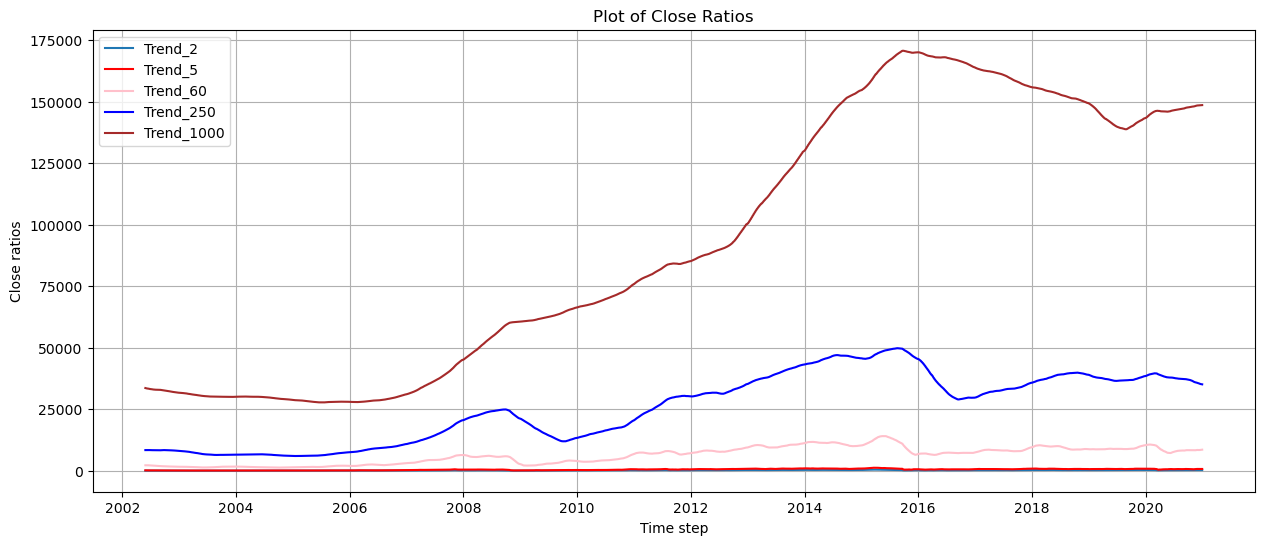

In [42]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['Trend_2'], label='Trend_2')
plt.plot(new_data['Trend_5'], color='r', label='Trend_5')
plt.plot(new_data['Trend_60'], color='pink', label='Trend_60')
plt.plot(new_data['Trend_250'], color='b', label='Trend_250')
plt.plot(new_data['Trend_1000'], color='brown', label='Trend_1000')
#plt.plot(new_data['close'], color='g', label='Close_Ratio_2')
plt.title('Plot of Close Ratios')
plt.ylabel('Close ratios')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

In [43]:
new_data['RSI']=data['RSI']
new_data['previousday']=data['previousday']

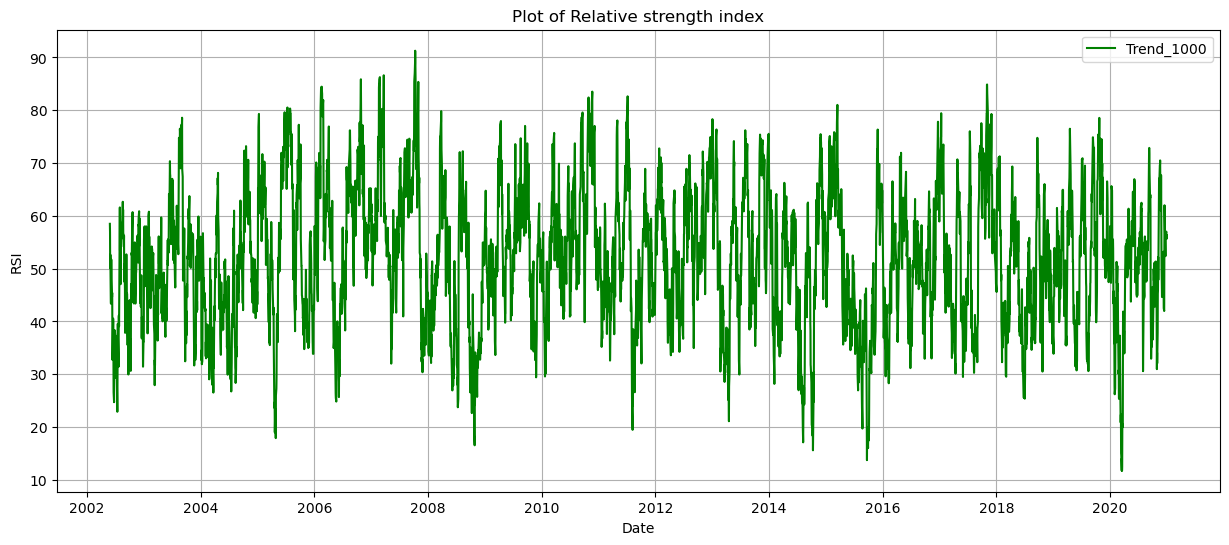

In [44]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['RSI'], color='g', label='Trend_1000')
#plt.plot(new_data['close'], color='g', label='Close_Ratio_2')
plt.title('Plot of Relative strength index')
plt.ylabel('RSI')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

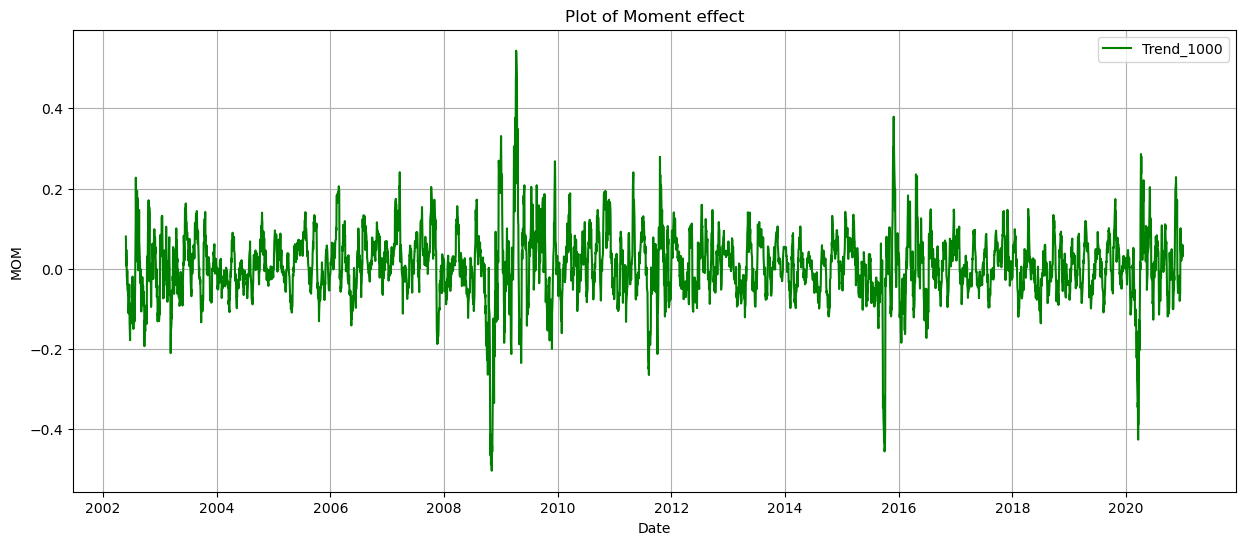

In [45]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(new_data['MOM'], color='g', label='Trend_1000')
#plt.plot(new_data['close'], color='g', label='Close_Ratio_2')
plt.title('Plot of Moment effect')
plt.ylabel('MOM')
plt.xlabel('Date')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

In [46]:
train = new_data.iloc[:-1000]
test = new_data.iloc[-1000:]

In [47]:
train.shape

(3744, 18)

In [48]:
new_data.columns

Index(['Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
       'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250',
       'Close_Ratio_1000', 'Trend_1000', 'close', 'MOM', 'SMA_3', 'SMA_4',
       'CMA_4', 'EMA', 'RSI', 'previousday'],
      dtype='object')

In [49]:
predictors= ['SMA_3','SMA_4','EMA','RSI','MOM', 'previousday'] 

#### Retrain the models on the new predictors

In [50]:
# creating a dictionary of Regressors to be experimented on.
models_dict = {
          'RF Regressor':RandomForestRegressor(random_state=0),
          'xgboost': XGBRegressor(),'Gradient Boost': GradientBoostingRegressor(random_state=0),
    'Catboostregressor':CatBoostRegressor(iterations=100, early_stopping_rounds=50)
         }

#looping through all the regressors, fitting and evaluating them on Cross validation and test data respectively
for key, model in models_dict.items():
    model.fit(train[predictors], train['close'])
    print(f'Performance of "{key}" on  Test set:')
    print('=='*28)
    print ( 'Test set:')
    print("**"*8)
    evaluate_model(model,test[predictors], test['close'])

Performance of "RF Regressor" on  Test set:
Test set:
****************
MAE: 1.57
MAPE: 0.01
minae: 0.00
maxae: 9.64
medae: 1.24

Performance of "xgboost" on  Test set:
Test set:
****************
MAE: 1.54
MAPE: 0.01
minae: 0.00
maxae: 7.43
medae: 1.28

Performance of "Gradient Boost" on  Test set:
Test set:
****************
MAE: 1.59
MAPE: 0.01
minae: 0.00
maxae: 11.71
medae: 1.28

Learning rate set to 0.327919
0:	learn: 40.7844602	total: 3.17ms	remaining: 314ms
1:	learn: 28.5277600	total: 6.16ms	remaining: 302ms
2:	learn: 20.3158671	total: 9.2ms	remaining: 298ms
3:	learn: 14.6005972	total: 11.8ms	remaining: 283ms
4:	learn: 10.6082545	total: 16ms	remaining: 304ms
5:	learn: 8.0575024	total: 18.8ms	remaining: 295ms
6:	learn: 6.4433848	total: 21.3ms	remaining: 283ms
7:	learn: 5.3298795	total: 23.7ms	remaining: 273ms
8:	learn: 4.6245171	total: 26.1ms	remaining: 264ms
9:	learn: 4.1318996	total: 28.8ms	remaining: 259ms
10:	learn: 3.8067362	total: 31.9ms	remaining: 258ms
11:	learn: 3.6155500	

#### Improving the model

In [51]:
#model_1 = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
#n_estimators=200, min_samples_split=50, random_state=1
model_2= GradientBoostingRegressor(random_state=0)

def predict(train, test, predictors_1, model_1):
    model_1.fit(train[predictors_1], train["Target"])
    preds_1 = model_1.predict_proba(test[predictors_1])[:,1]
    preds_1[preds_1 >=.6] = 1
    preds_1[preds_1 <.6] = 0
    preds_1 = pd.Series(preds_1, index=test.index, name="Predictions_1")
    combined_1 = pd.concat([test["Target"], preds_1], axis=1)
    return combined_1 

In [52]:
def predict(train, test, predictors, model_2):
    model_2.fit(train[predictors], train["close"])
    preds_2 = model_2.predict(test[predictors])
    preds_2 = pd.Series(preds_2, index=test.index, name="Predictions_2")
    combined_2 = pd.concat([test["close"], preds_2], axis=1)
    return combined_2

In [53]:
def backtest(new_data, model_2, predictors, start=1500, step=250):
    all_predictions = []

    for i in range(start, new_data.shape[0], step):
        train = new_data.iloc[0:i].copy()
        test = new_data.iloc[i:(i+step)].copy()
        predictions_2 = predict(train, test, predictors, model_2)
        all_predictions.append(predictions_2)
    
    return pd.concat(all_predictions)

In [54]:
predictions_2 = backtest(new_data, model_2, predictors)

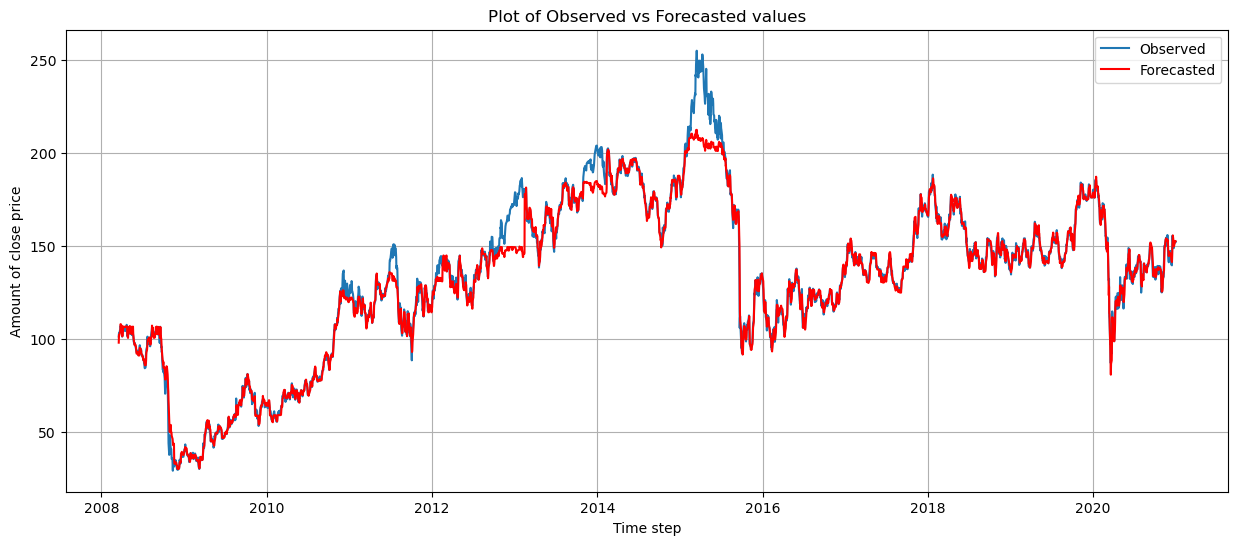

In [55]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(predictions_2['close'], label='Observed')
plt.plot(predictions_2['Predictions_2'], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

In [56]:
model_2.fit(train[predictors], train['close'])
prediction=model.predict(test[predictors])

In [57]:
mape= mean_absolute_percentage_error(test['close'], prediction)
mae=mean_absolute_error(test['close'], prediction)

In [58]:
print('mean absolute percentage error is : {}\n'.format(mape))
print('mean absolute  error is : {}\n'.format(mae))

mean absolute percentage error is : 0.012308061715402822

mean absolute  error is : 1.795204412201557



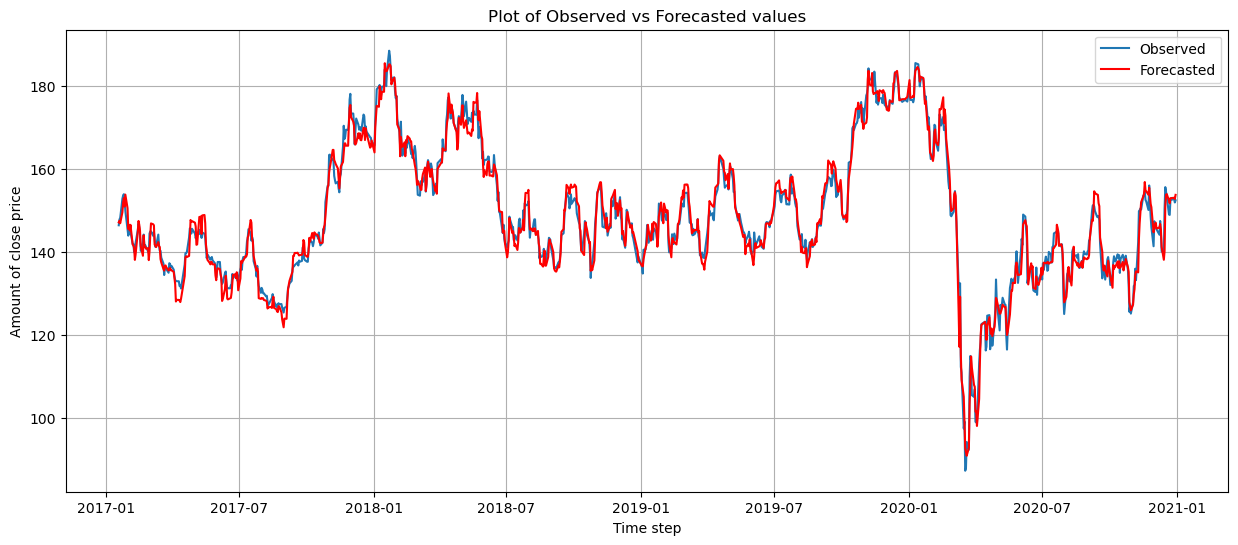

In [59]:
# Plot the test predictions and true values
pred= pd.Series(prediction, index=test.index)
plt.figure(figsize=(15,6))
plt.plot(test['close'], label='Observed')
plt.plot(pred, color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

#### Perform Hyper parameter tuning using grid searchcv

#possibe hyperparameters for random forest
hyper = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 6]
}

from sklearn.model_selection import GridSearchCV

cv_model= GridSearchCV(GradientBoostingRegressor(), param_grid=hyper)
cv_model.fit(train[predictors], train['close'])

print(cv_model.best_score_)
print(cv_model.best_estimator_)

In [60]:
model = GradientBoostingRegressor(max_depth=5, n_estimators=100, learning_rate=0.1, min_samples_split=5)
model.fit(train[predictors], train['close'])
prediction=model.predict(test[predictors])

In [61]:
grdb_mae =  mean_absolute_error(test['close'], prediction)
abs_errors= np.abs(np.array(prediction) - np.array(test['close']))
grdb_min_abs_errors= np.min(abs_errors)
grdb_max_abs_errors= np.max(abs_errors)
grdb_med_abs_errors= np.median(abs_errors)
grdb_mape = mean_absolute_percentage_error(test['close'], prediction)

In [62]:
print(f"Optimized Gradient boosting Performance Metrics \n\n \
gradientboost Mae: {grdb_mae} \n \
gradientboost minae: {grdb_min_abs_errors} \n \
gradientboost maxae: {grdb_max_abs_errors} \n \
gradientboost medae: {grdb_med_abs_errors} \n \
gradientboost Mape: {grdb_mape} \n \
 \n\n <-------------------------------------------------->\n")

Optimized Gradient boosting Performance Metrics 

 gradientboost Mae: 1.4957692636031592 
 gradientboost minae: 0.008577747499145971 
 gradientboost maxae: 8.782214504952265 
 gradientboost medae: 1.2354961319283575 
 gradientboost Mape: 0.010342422272752049 
  

 <-------------------------------------------------->



In [63]:
pred= pd.Series(prediction, index=test.index)
combined= pd.concat([test['close'], pred],axis=1)
combined 

,close,0
date,,
2017-01-18,146.399994,146.846127
2017-01-19,147.800003,146.846127
2017-01-20,148.199997,148.477765
2017-01-23,152.800003,150.219599
2017-01-24,153.600006,153.180764
...,...,...
2020-12-22,148.899994,150.167115
2020-12-23,152.460007,151.172011
2020-12-28,152.759995,153.232434


In [64]:
mape= mean_absolute_percentage_error(test['close'], prediction)
mae=mean_absolute_error(test['close'], prediction)

In [65]:
print('mean absolute percentage error is : {}\n'.format(mape))
print('mean absolute  error is : {}\n'.format(mae))

mean absolute percentage error is : 0.010342422272752049

mean absolute  error is : 1.4957692636031592



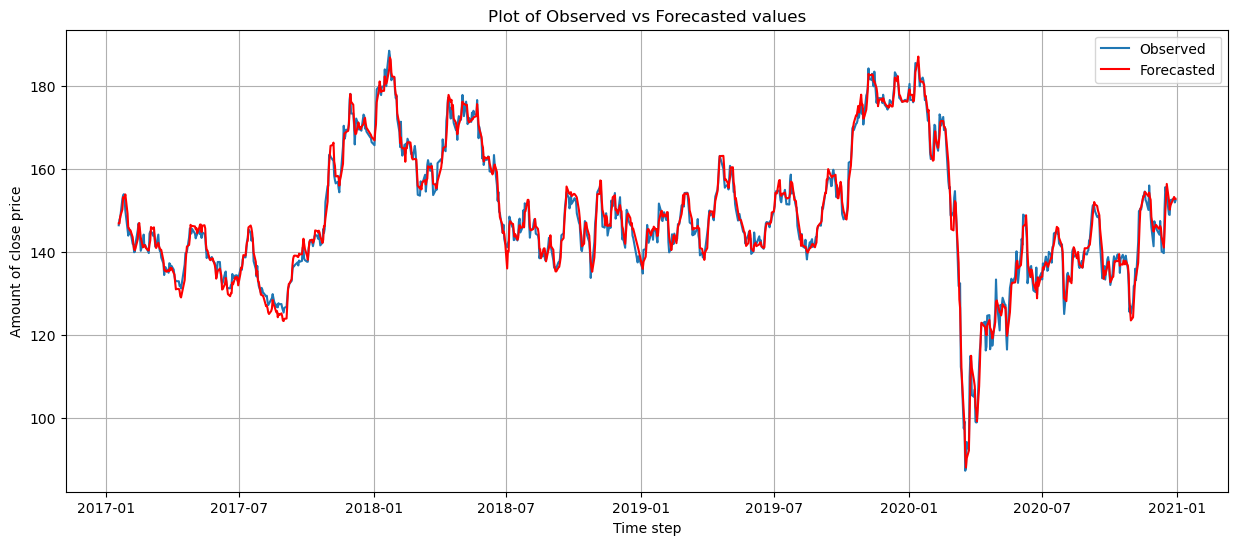

In [66]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined['close'], label='Observed')
plt.plot(combined[0], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

### Stacking and Bagging

In [67]:
# List of machine learning algorithms to consider
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso,ElasticNet 
algorithms = [
    ('Linear regression', LinearRegression(), {}),
    ('Ridge', Ridge(), {}),
    ('Lasso', Lasso(), {}),
    ('Elastic Net', ElasticNet(), {}),
    #('SVM', SVC(kernel='linear', probability=True, decision_function_shape='ovr'), {}),
    ('MLP', MLPRegressor(), {})
]

# Train base models
base_models = {}
for algorithm_name, algorithm, _ in algorithms:
    print(algorithm)
    model = algorithm
    model.fit(train[predictors], train['close'])
    base_models[algorithm_name] = model

eval_metrics = ['mae', 'mape']
results = pd.DataFrame(columns=['Algorithm'] + eval_metrics)

for algorithm_name, model in base_models.items():
    y_pred = model.predict(test[predictors])
    mae= mean_absolute_error(test['close'], y_pred)
    mape =mean_absolute_percentage_error(test['close'], y_pred)

# Ensembling using Bagging with all base models
bagging_model = BaggingRegressor(base_estimator=None, n_estimators=10, random_state=42)
bagging_model.fit(train[predictors], train['close'])
bagging_y_pred = bagging_model.predict(test[predictors])
bagging_mae = mean_absolute_error(test['close'], bagging_y_pred)
abs_errors= np.abs(np.array(bagging_y_pred) - np.array(test['close']))
bagg_min_abs_errors= np.min(abs_errors)
bagg_max_abs_errors= np.max(abs_errors)
bagg_med_abs_errors= np.median(abs_errors)
bagging_mape = mean_absolute_percentage_error(test['close'], bagging_y_pred)
print(f"Bagging Ensemble Method Performance Metrics \n\n \
bagging Mae: {bagging_mae} \n \
bagging minae: {bagg_min_abs_errors} \n \
bagging maxae: {bagg_max_abs_errors} \n \
bagging medae: {bagg_med_abs_errors} \n \
bagging Mape: {bagging_mape} \n \
 \n\n <-------------------------------------------------->\n")

# Ensembling using Stacking
meta_model = Ridge()
stacking_model = StackingRegressor(estimators=list(base_models.items()), final_estimator=meta_model)
stacking_model.fit(train[predictors], train['close'])
stacking_y_pred = stacking_model.predict(test[predictors])
stacking_mae =  mean_absolute_error(test['close'], stacking_y_pred)
abs_errors= np.abs(np.array(stacking_y_pred) - np.array(test['close']))
stack_min_abs_errors= np.min(abs_errors)
stack_max_abs_errors= np.max(abs_errors)
stack_med_abs_errors= np.median(abs_errors)
stacking_mape = mean_absolute_percentage_error(test['close'], stacking_y_pred)
print(f"Stacking Ensemble Method Performance Metrics \n\n \
stacking mae: {stacking_mae} \n \
stacking minae: {stack_min_abs_errors} \n \
stacking maxae: {stack_max_abs_errors} \n \
stacking medae: {stack_med_abs_errors} \n \
stacking mape: {stacking_mape} \n")




#print(f"Stacking F1 Score: {stacking_f1}")


LinearRegression()
Ridge()
Lasso()
ElasticNet()
MLPRegressor()
Bagging Ensemble Method Performance Metrics 

 bagging Mae: 1.7299643228999995 
 bagging minae: 4.500000045482011e-06 
 bagging maxae: 11.174995999999993 
 bagging medae: 1.3875020499999806 
 bagging Mape: 0.012016927251630592 
  

 <-------------------------------------------------->

Stacking Ensemble Method Performance Metrics 

 stacking mae: 1.179977419522763 
 stacking minae: 0.0009667741784937789 
 stacking maxae: 6.965648157922203 
 stacking medae: 0.8854444248392355 
 stacking mape: 0.0081701464051104 



In [68]:
bagging_y_pred= pd.Series(bagging_y_pred, index=test.index)
stacking_y_pred= pd.Series(stacking_y_pred, index=test.index)

In [69]:
combined_stack= pd.concat([test['close'], stacking_y_pred],axis=1)
combined_bagg= pd.concat([test['close'], bagging_y_pred], axis=1)

In [70]:
combined_bagg.head()

,close,0
date,,
2017-01-18,146.399994,146.214998
2017-01-19,147.800003,146.404997
2017-01-20,148.199997,148.030002
2017-01-23,152.800003,150.275000
2017-01-24,153.600006,153.435001


In [71]:
combined_stack

,close,0
date,,
2017-01-18,146.399994,145.294431
2017-01-19,147.800003,147.430124
2017-01-20,148.199997,147.768651
2017-01-23,152.800003,151.948606
2017-01-24,153.600006,152.223919
...,...,...
2020-12-22,148.899994,150.012426
2020-12-23,152.460007,150.049704
2020-12-28,152.759995,151.684247


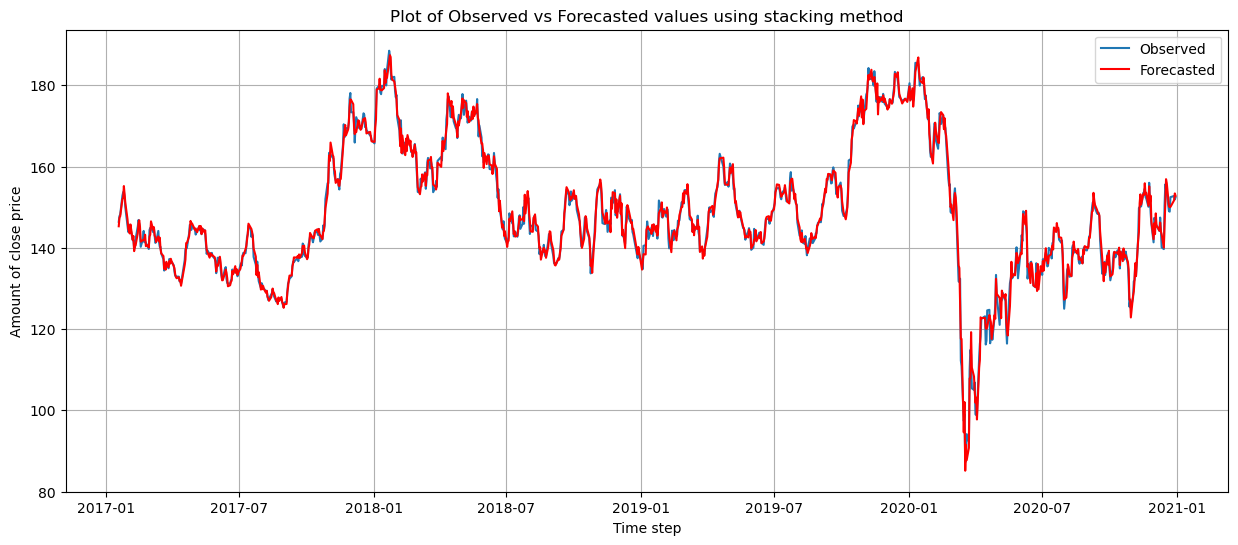

In [72]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined_stack['close'], label='Observed')
plt.plot(combined_stack[0], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values using stacking method')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

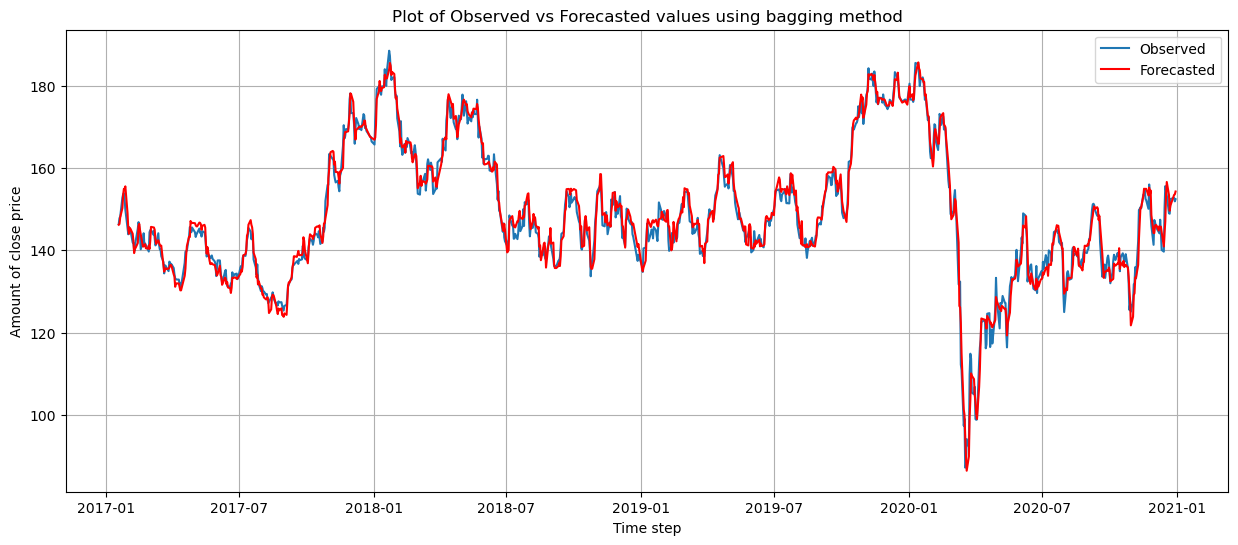

In [73]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined_bagg['close'], label='Observed')
plt.plot(combined_bagg[0], color='r', label='Forecasted')
plt.title('Plot of Observed vs Forecasted values using bagging method')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('forcast.png')
plt.show()

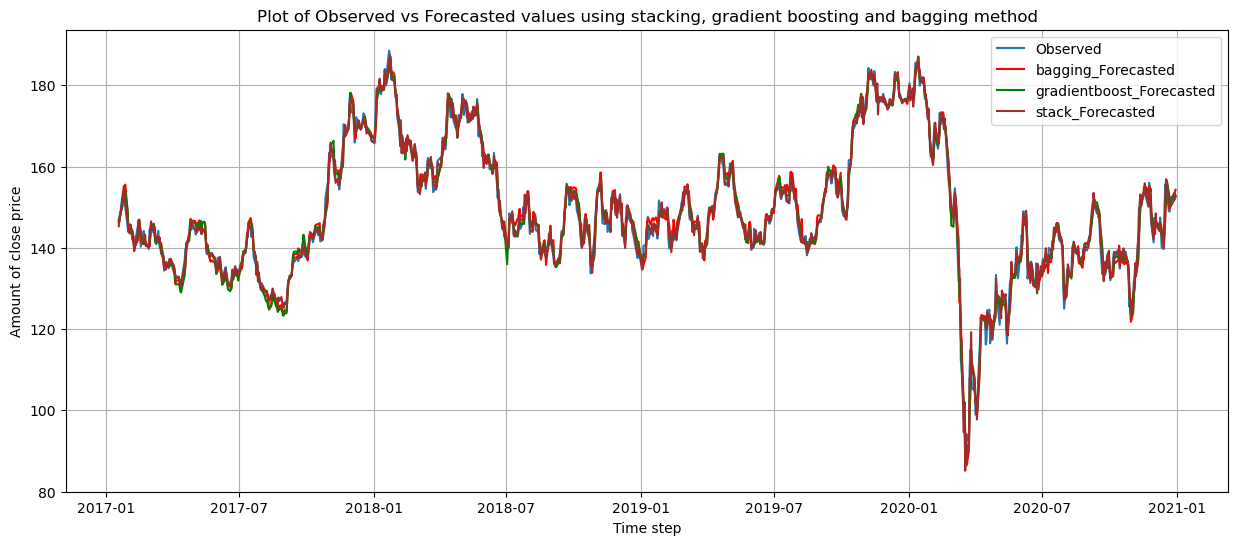

In [74]:
# Plot the test predictions and true values
plt.figure(figsize=(15,6))
plt.plot(combined_bagg['close'], label='Observed')
plt.plot(combined_bagg[0], color='r', label='bagging_Forecasted')
plt.plot(combined[0], color='green', label='gradientboost_Forecasted')
plt.plot(combined_stack[0], color='brown', label='stack_Forecasted')
plt.title('Plot of Observed vs Forecasted values using stacking, gradient boosting and bagging method')
plt.ylabel('Amount of close price')
plt.xlabel('Time step')
plt.legend()
plt.grid()
plt.savefig('Volkswagenresult.png')
plt.show()

In [75]:
from prettytable import PrettyTable
import joblib
import os
# Constructing the result summary table containing the scores for each model on  test dataset.

task1_result = PrettyTable()
task1_result.field_names = ["Regressor", "MAE on Test","MAPE on Test", "MinAE on Test", "MaxAE on Test", "MedAE on Test"]
task1_result.add_row(['RF Reg', 1.57, 0.01, 0.00, 9.64, 1.24])
task1_result.add_row(['XGboost', 1.54, 0.01, 0.00, 7.43, 1.28])
task1_result.add_row(['GradientBoost', 1.59, 0.01, 0.00, 11.71, 1.28])
task1_result.add_row(['Catboost', 1.80, 0.01, 0.00, 14.47, 1.49])
task1_result.add_row(['Bagging', 1.73, 0.01, 4.50, 11.17, 1.39])
task1_result.add_row(['Stacking', 1.19, 0.01, 0.00, 7.28, 0.91])

print('Result Summary for All Regressors :')
print(task1_result)

Result Summary for All Regressors :
+---------------+-------------+--------------+---------------+---------------+---------------+
|   Regressor   | MAE on Test | MAPE on Test | MinAE on Test | MaxAE on Test | MedAE on Test |
+---------------+-------------+--------------+---------------+---------------+---------------+
|     RF Reg    |     1.57    |     0.01     |      0.0      |      9.64     |      1.24     |
|    XGboost    |     1.54    |     0.01     |      0.0      |      7.43     |      1.28     |
| GradientBoost |     1.59    |     0.01     |      0.0      |     11.71     |      1.28     |
|    Catboost   |     1.8     |     0.01     |      0.0      |     14.47     |      1.49     |
|    Bagging    |     1.73    |     0.01     |      4.5      |     11.17     |      1.39     |
|    Stacking   |     1.19    |     0.01     |      0.0      |      7.28     |      0.91     |
+---------------+-------------+--------------+---------------+---------------+---------------+
